In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

In [2]:
import graphufs
from graphufs.utils import open_zarr, open_dataset

plt.style.use("graphufs.plotstyle")

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [6]:
gds = open_zarr("/p1-evaluation/v1/validation/graphufs.240h.zarr/")
gdm = open_zarr("/p1-evaluation/gdm/v1-clipped/validation/graphufs_gdm.240h.zarr/")

In [7]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr",
    storage_options={"token": "anon"},
)
era = era.sel(
    time=slice(
        gds.time.isel(time=0).values,
        gds.valid_time.isel(time=-1, fhr=-1).values
    ),
    level=[100,500,850],
)

In [8]:
rds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.zarr",
    storage_options={"token":"anon"},
)
rds = rds.sel(
    time=slice(
        gds.time.isel(time=0).values,
        gds.valid_time.isel(time=-1, fhr=-1).values,
    ),
    pfull=gdm.level.values,
)
rds = rds.rename({"pfull": "level", "grid_yt": "lat", "grid_xt": "lon"})

In [9]:
gds["10m_wind_speed"] = np.sqrt(gds["ugrd10m"]**2 + gds["vgrd10m"]**2)
gdm["10m_wind_speed"] = np.sqrt(gdm["ugrd10m"]**2 + gdm["vgrd10m"]**2)
era["10m_wind_speed"] = np.sqrt(era["10m_u_component_of_wind"]**2 + era["10m_v_component_of_wind"]**2)

In [10]:
from graphufs.spatialmap import SpatialMap

In [11]:
mapper = SpatialMap()

In [12]:
gds.time[30]

<xarray.DataArray 'time' ()> Size: 8B
array('2022-02-03T21:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2022-02-03T21:00:00

In [13]:
gdm.time[11]

NameError: name 'gdm2' is not defined

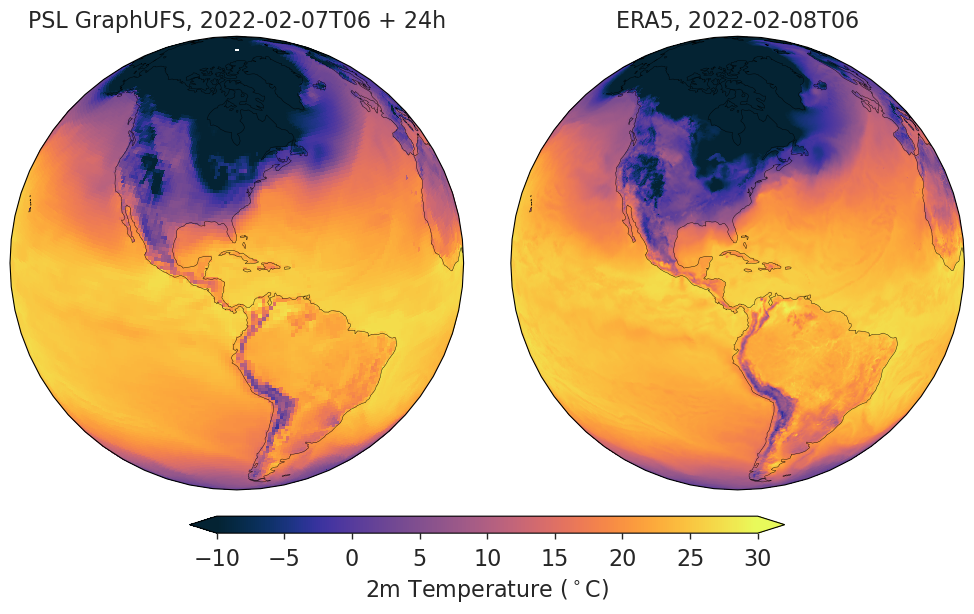

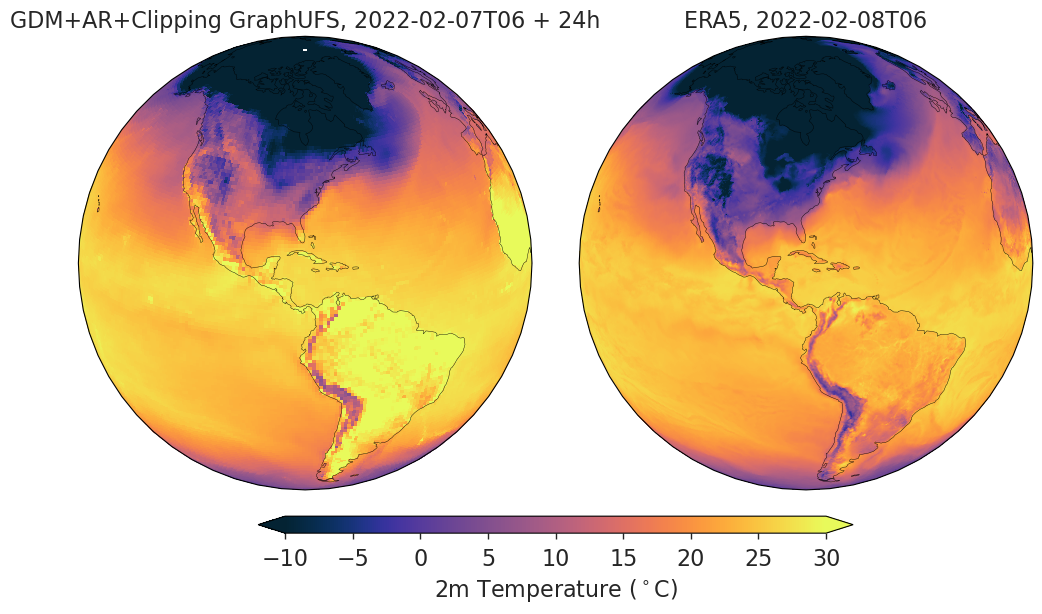

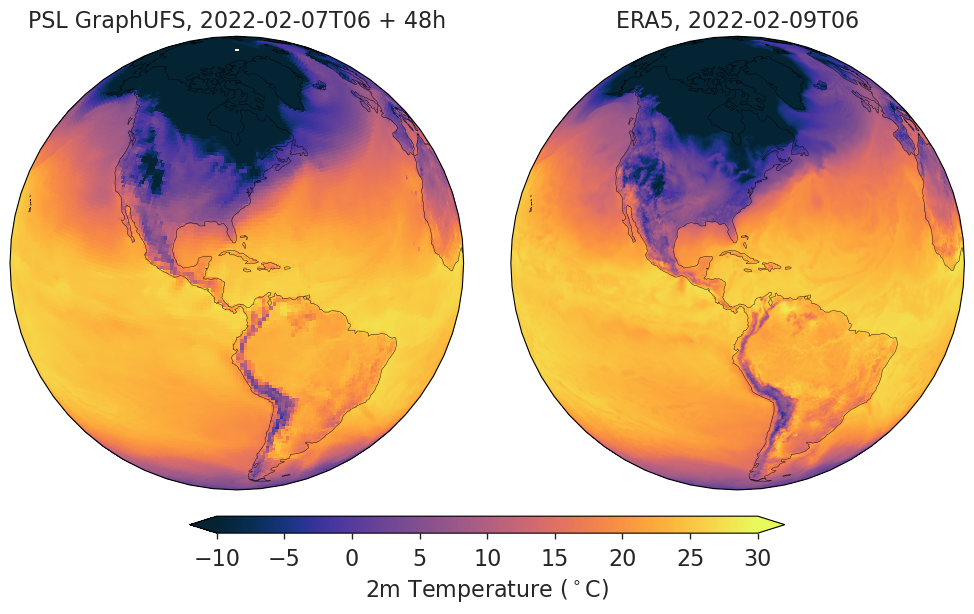

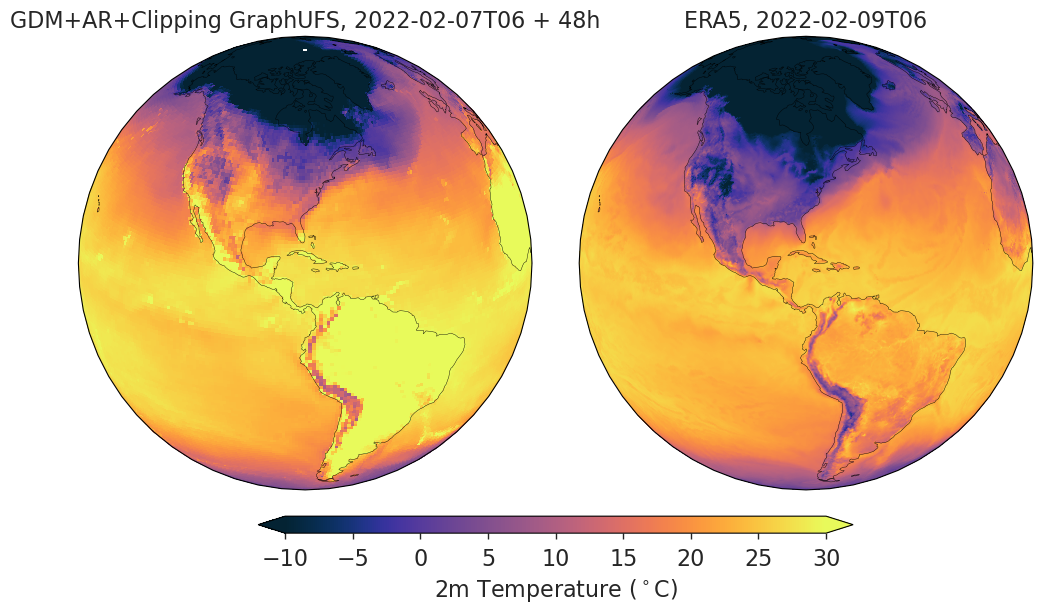

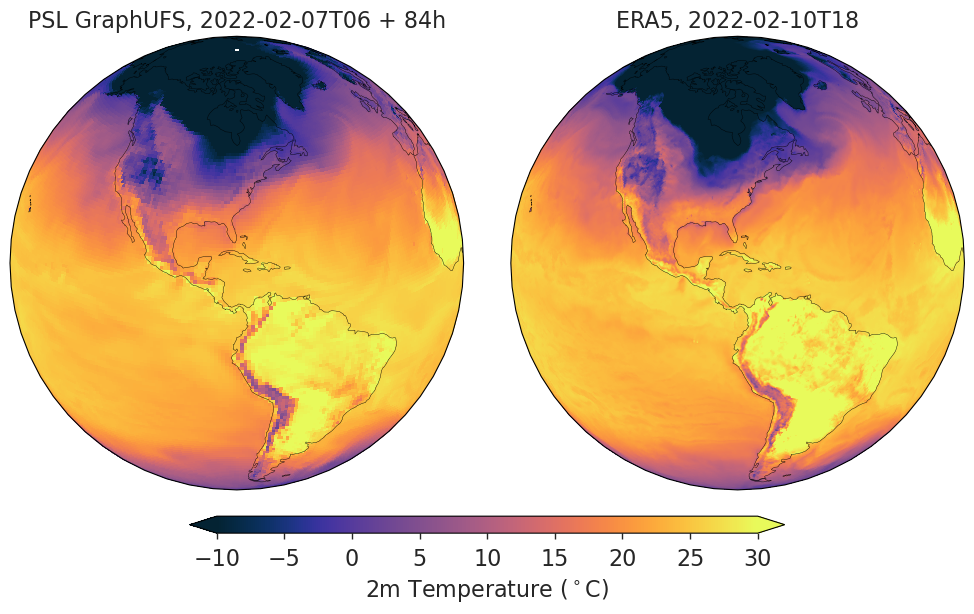

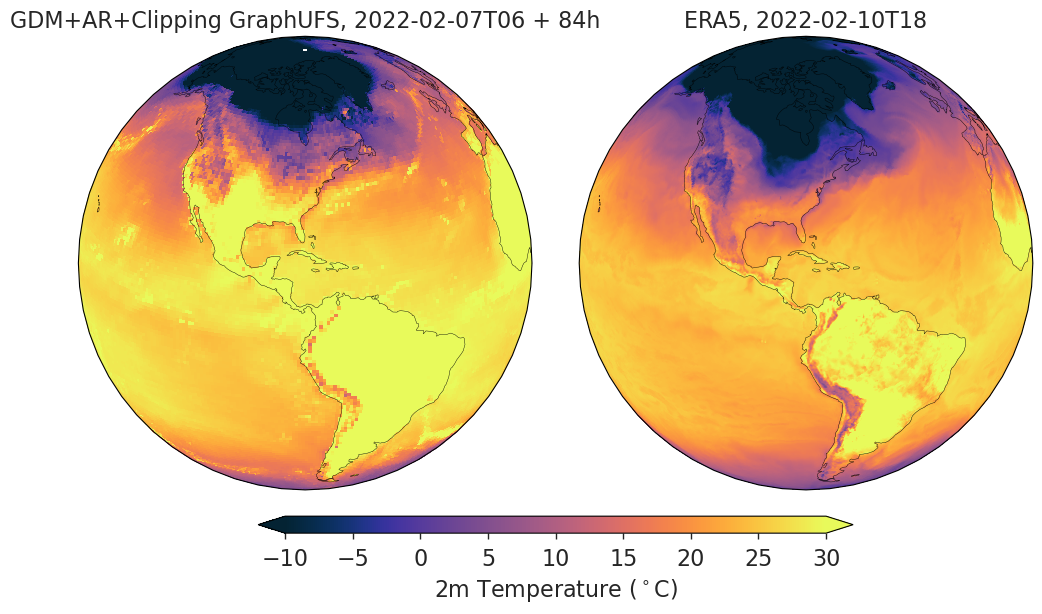

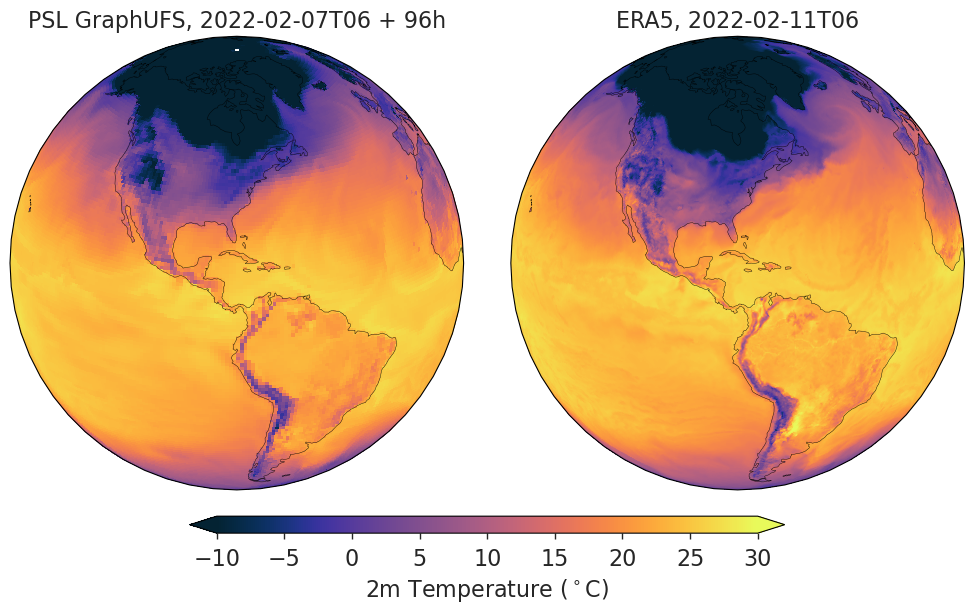

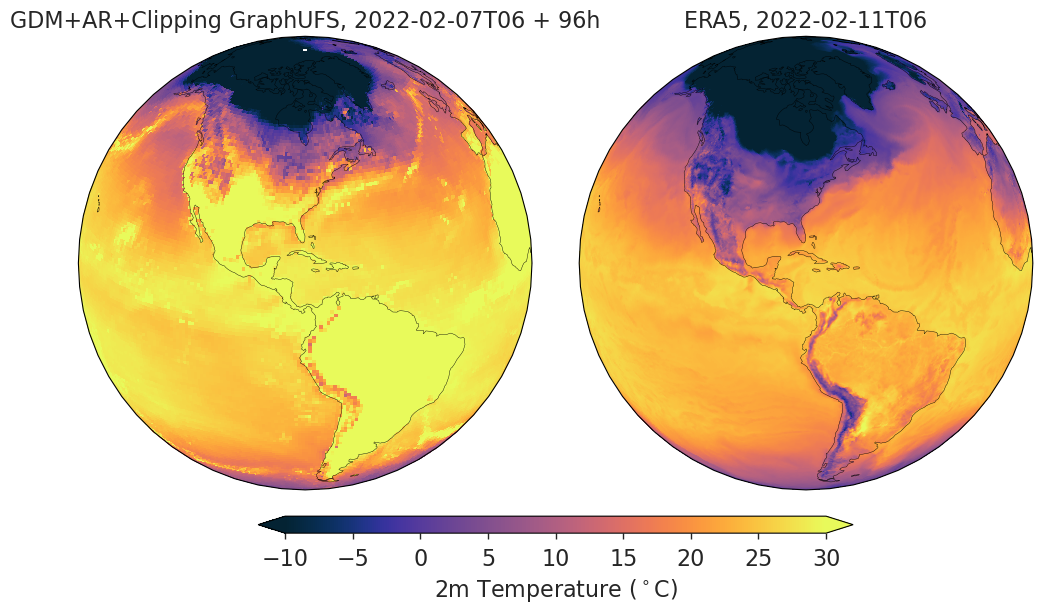

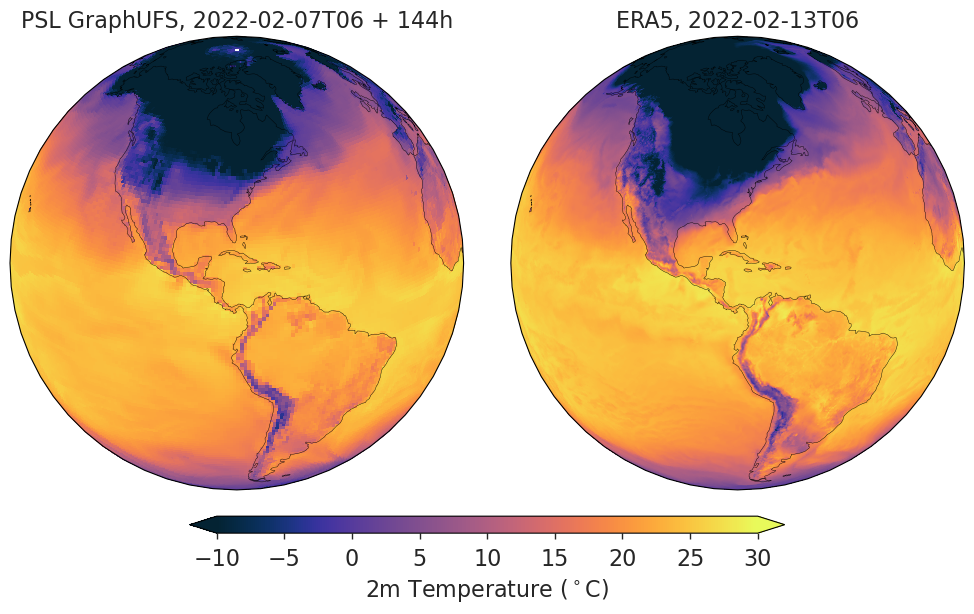

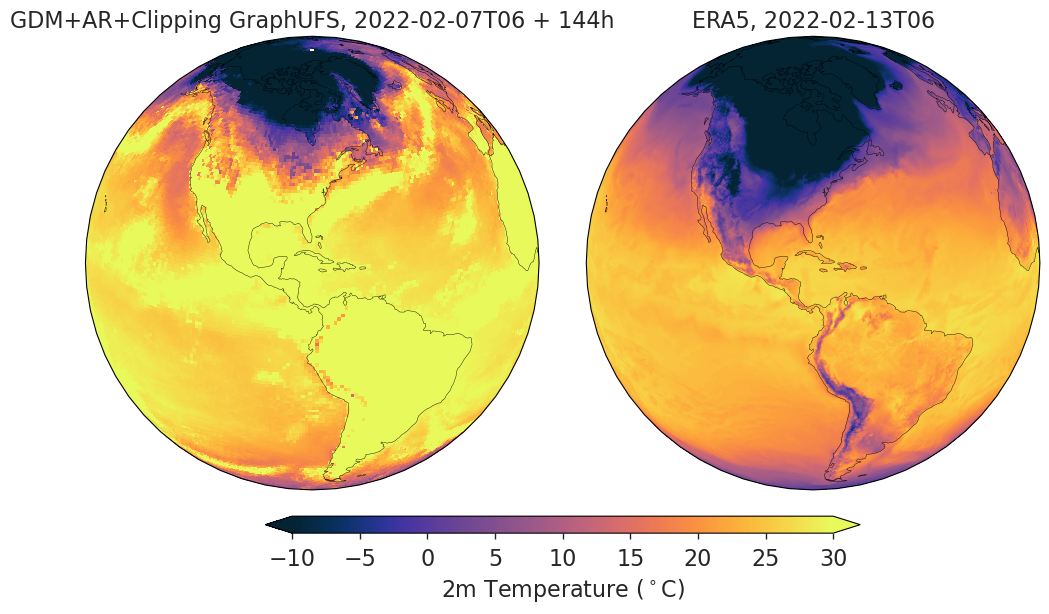

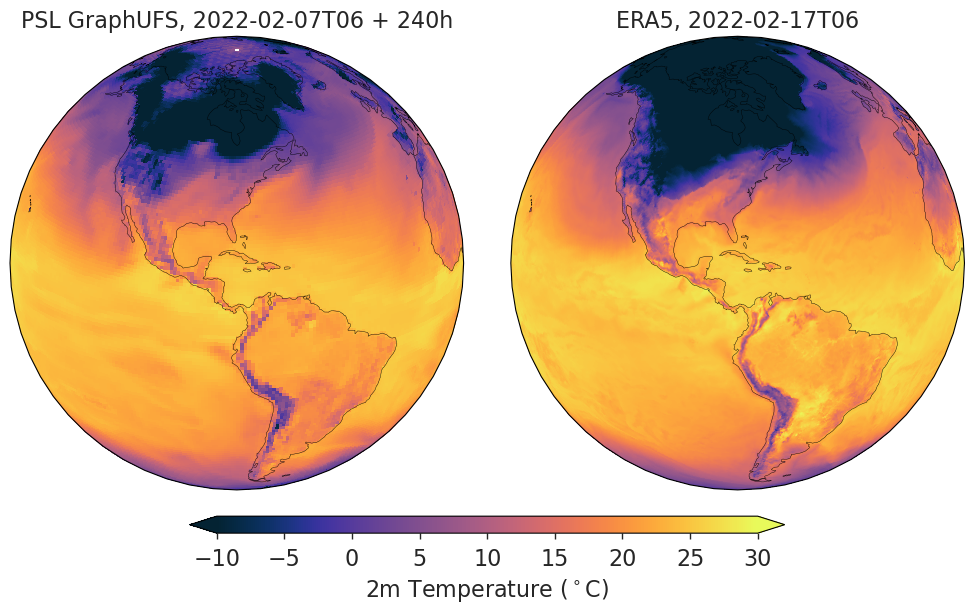

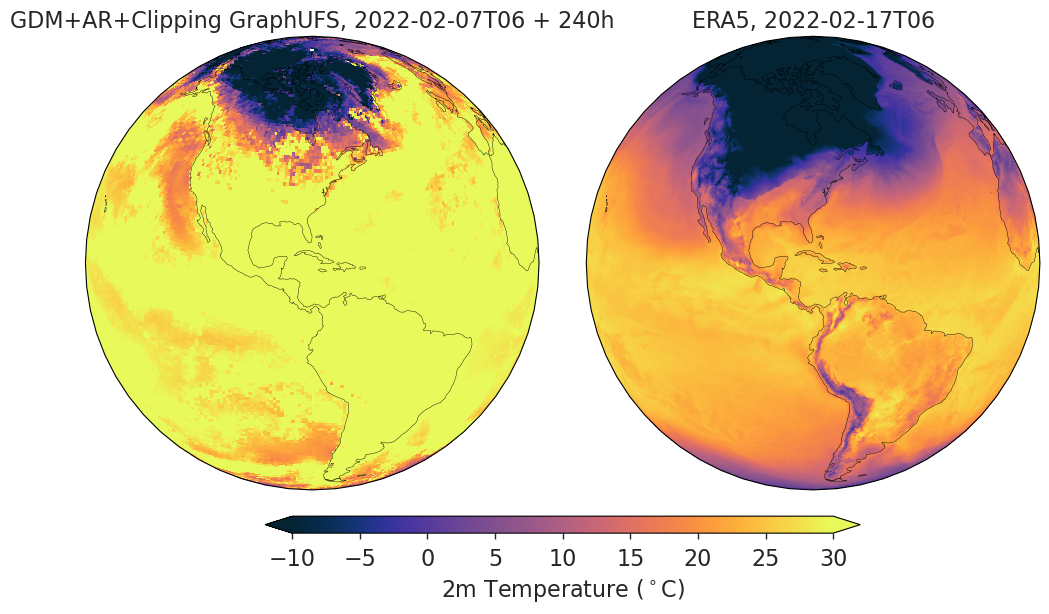

In [14]:
#date = "2022-07-21T12"
#date = "2022-02-09T12"
date = "2022-02-07T06"

gkey = "tmp2m"
ekey = "2m_temperature"
kw = {}

#gkey = "ugrd10m"
#ekey = "10m_u_component_of_wind"
#kw = {"cmap": "cmo.balance", "vmin": -20, "vmax": 20}

for fhr in [24, 24*2, 24*3 + 12, 24 * 4, 24 * 6, 24 * 10]:
    for xds, label  in zip([gds, gdm], ["PSL", "GDM+AR+Clipping"]):
        
        plotme = xds[gkey].sel(time=date, fhr=fhr)
        fig, axs = mapper.plot(
            plotme,
            era[ekey].sel(time=[plotme.valid_time.values]),
            **kw
        )
        axs[0].set(title=label+" "+axs[0].get_title())
        fig.savefig(f"figures/graphufs_{label.lower()}_and_era5_{gkey}_{fhr}h.jpeg", bbox_inches="tight", dpi=300)

In [16]:
xrds = rds.sel(time=slice(date, pd.Timestamp(date) + pd.Timedelta(hours=240)))
for key in gdm.data_vars:
    print(f" --- {key} --- ")
    print(f"Max: Replay = {xrds[key].max().values}, GDM = {gdm[key].sel(time=date).max().values}",)
    print(f"Min: Replay = {xrds[key].min().values}, GDM = {gdm[key].sel(time=date).min().values}",)
    print()

 --- clwmr --- 
Max: Replay = 0.0019349714275449514, GDM = 0.010958460159599781
Min: Replay = 0.0, GDM = 0.0

 --- dpres --- 
Max: Replay = 1790.4737548828125, GDM = 2174.56982421875
Min: Replay = 0.6059979200363159, GDM = 0.6059291958808899

 --- f10m --- 
Max: Replay = 1.089292287826538, GDM = 1.3022031784057617
Min: Replay = 0.941690981388092, GDM = 0.9554507732391357

 --- grle --- 
Max: Replay = 0.0008353766752406955, GDM = 0.0006201312644407153
Min: Replay = 0.0, GDM = 0.0

 --- icmr --- 
Max: Replay = 0.0006755212671123445, GDM = 0.002681480022147298
Min: Replay = 0.0, GDM = 0.0

 --- nicp --- 
Max: Replay = 14422978.0, GDM = 88205448.0
Min: Replay = 0.0, GDM = 0.0

 --- ntrnc --- 
Max: Replay = 35775.75390625, GDM = 44673.68359375
Min: Replay = 0.0, GDM = 0.0

 --- o3mr --- 
Max: Replay = 1.670288111199625e-05, GDM = 7.834150164853781e-05
Min: Replay = -2.6955579990328715e-09, GDM = 2.7835163063372192e-09

 --- prateb_ave --- 
Max: Replay = 0.008994936011731625, GDM = 0.0106684

KeyError: "No variable named '10m_wind_speed'. Variables on the dataset include ['acond', 'albdo_ave', 'alnsf', 'alnwf', 'alvsf', ..., 'xu', 'xv', 'xz', 'xzts', 'zc']"

In [21]:
xrds = rds.sel(time=slice(date, pd.Timestamp(date) + pd.Timedelta(hours=240)))
for key in [
    "spfh",
    "o3mr",
    "clwmr",
    "grle",
    "icmr", 
    "rwmr",
    "snmr",
    "ntrnc",
    "nicp",
    "soill1",
    "soilw1",
    "snod",
    "weasd",
    "f10m",
    "sfcr",
    "prateb_ave",
    "tmp",
    "tmp2m",
    "ugrd",
    "vgrd",
    "ugrd10m",
    "vgrd10m",
]:
    print(f" --- {key} --- ")
    print(f"Max: Replay = {xrds[key].max().values}, GDM = {gdm[key].sel(time=date).max().values}",)
    print(f"Min: Replay = {xrds[key].min().values}, GDM = {gdm[key].sel(time=date).min().values}",)
    print()

 --- spfh --- 
Max: Replay = 0.023561587557196617, GDM = 0.11893115937709808
Min: Replay = 0.0, GDM = 9.999514549718924e-10

 --- o3mr --- 
Max: Replay = 1.670288111199625e-05, GDM = 7.917629409348592e-05
Min: Replay = -2.6955579990328715e-09, GDM = 2.7835163063372192e-09

 --- clwmr --- 
Max: Replay = 0.0019349714275449514, GDM = 0.010215715505182743
Min: Replay = 0.0, GDM = 0.0

 --- grle --- 
Max: Replay = 0.0008353766752406955, GDM = 0.0005462910630740225
Min: Replay = 0.0, GDM = 0.0

 --- icmr --- 
Max: Replay = 0.0006755212671123445, GDM = 0.0016671607736498117
Min: Replay = 0.0, GDM = 0.0

 --- icmr --- 
Max: Replay = 0.0006755212671123445, GDM = 0.0016671607736498117
Min: Replay = 0.0, GDM = 0.0

 --- rwmr --- 
Max: Replay = 0.0027461734134703875, GDM = 0.003194187069311738
Min: Replay = 0.0, GDM = 0.0

 --- snmr --- 
Max: Replay = 0.010911836288869381, GDM = 0.018450753763318062
Min: Replay = 0.0, GDM = 0.0

 --- ntrnc --- 
Max: Replay = 35775.75390625, GDM = 60733.1875
Min: R